In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal

%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [2]:
#leitura do dataset original
df = pd.read_csv("NYPD_Complaint_Data_Current_YTD.csv")
df

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,736216184,09/30/2016,23:25:00,09/30/2016,23:25:00,09/30/2016,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",...,42.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1015308.0,244373.0,40.837376,-73.887761,"(40.837376359, -73.887760929)"
1,294332956,09/30/2016,23:16:00,09/30/2016,23:21:00,09/30/2016,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,71.0,OPPOSITE OF,STREET,NaN,NaN,997932.0,180172.0,40.661205,-73.950687,"(40.661204871, -73.950686652)"
2,852981427,09/30/2016,23:00:00,09/30/2016,23:05:00,09/30/2016,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,43.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,CASTLE HILL,1025580.0,236918.0,40.816872,-73.850685,"(40.816872438, -73.850684927)"
3,369976063,09/30/2016,23:00:00,NaN,NaN,09/30/2016,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,...,103.0,NaN,STREET,NaN,NaN,1038464.0,192970.0,40.696177,-73.804492,"(40.696177006, -73.804492266)"
4,117213771,09/30/2016,23:00:00,09/30/2016,23:10:00,09/30/2016,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,110.0,FRONT OF,STREET,NaN,NaN,1016301.0,209428.0,40.741458,-73.884339,"(40.741458245, -73.884339073)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361735,582350583,01/01/2015,03:50:00,01/01/2016,04:00:00,01/01/2016,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,30.0,INSIDE,HOTEL/MOTEL,NaN,NaN,998372.0,240146.0,40.825818,-73.948975,"(40.825817778, -73.948974825)"
361736,258046495,01/01/2015,01:25:00,01/01/2016,01:30:00,01/01/2016,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,41.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1014468.0,238156.0,40.820315,-73.890825,"(40.820315396, -73.890824603)"
361737,640212578,01/01/2015,00:30:00,01/01/2016,00:40:00,01/01/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,109.0,FRONT OF,BAR/NIGHT CLUB,NaN,NaN,1030529.0,214093.0,40.754199,-73.832963,"(40.754199468, -73.832962523)"
361738,496500431,06/30/2014,12:00:00,12/29/2015,12:00:00,01/01/2016,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,50.0,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1009735.0,261272.0,40.883777,-73.907837,"(40.883776851, -73.907836928)"


In [3]:
#contagem das ocorrencias por dia
NUM_OCURR=df['CMPLNT_FR_DT'].value_counts()
NUM_OCURR


01/01/2016    2077
06/01/2016    1731
04/01/2016    1728
07/01/2016    1536
03/01/2016    1503
              ... 
12/20/2013       1
10/30/2009       1
05/15/1016       1
05/29/2014       1
12/31/2001       1
Name: CMPLNT_FR_DT, Length: 1517, dtype: int64

In [4]:
#criação do dataframe com o dia e número de ocorrências 
d1 = pd.DataFrame(data=NUM_OCURR.index, columns=['CMPLNT_FR_DT'])
d2 = pd.DataFrame(data=NUM_OCURR.values, columns=['NUM_OCURR'])
d = pd.merge(d1, d2, left_index=True, right_index=True)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CMPLNT_FR_DT  1517 non-null   object
 1   NUM_OCURR     1517 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.8+ KB


In [5]:
d.sort_values(by=['CMPLNT_FR_DT'])

,CMPLNT_FR_DT,NUM_OCURR
1336,01/01/1978,1
1433,01/01/1983,1
1228,01/01/1985,1
1266,01/01/1986,1
1352,01/01/1988,1
...,...,...
943,12/31/2011,1
823,12/31/2012,2
767,12/31/2013,2
1501,12/31/2014,1


In [6]:
#eliminação das observações fora do formato compatível a data
d['CMPLNT_FR_DT'] = pd.to_datetime(d['CMPLNT_FR_DT'], errors='coerce')

In [7]:
#transformação do tipo da coluna 'CMPLNT_FR_DT' para datatime e agregação por mês
d['CMPLNT_FR_DT'] = pd.to_datetime(d['CMPLNT_FR_DT'])
dm = d.groupby(d['CMPLNT_FR_DT'].dt.to_period('M'))['NUM_OCURR'].sum()


In [8]:
dfmonthly = dm.to_frame().reset_index()

In [9]:
dfmonthly 

,CMPLNT_FR_DT,NUM_OCURR
0,1912-11,1
1,1914-04,1
2,1915-12,1
3,1916-01,1
4,1916-02,1
...,...,...
203,2016-05,41463
204,2016-06,41159
205,2016-07,40901
206,2016-08,41405


In [10]:
#limpeza do dataset
dfmonthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   CMPLNT_FR_DT  208 non-null    period[M]
 1   NUM_OCURR     208 non-null    int64    
dtypes: int64(1), period[M](1)
memory usage: 3.4 KB


In [11]:
dfmonthly['ano'] = dfmonthly['CMPLNT_FR_DT'].dt.year
dfmonthly['mes'] = dfmonthly['CMPLNT_FR_DT'].dt.month

In [12]:
dfmonthly['mes'] = dfmonthly['mes'].astype(int)
dfmonthly['ano'] = dfmonthly['ano'].astype(int)

In [13]:
dfmonthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   CMPLNT_FR_DT  208 non-null    period[M]
 1   NUM_OCURR     208 non-null    int64    
 2   ano           208 non-null    int32    
 3   mes           208 non-null    int32    
dtypes: int32(2), int64(1), period[M](1)
memory usage: 5.0 KB


In [14]:
#analisar em qual espaço de tempo temos todas as observações mensais
dfmonthly.groupby(['ano']).count()

,CMPLNT_FR_DT,NUM_OCURR,mes
ano,,,
1912,1,1,1
1914,1,1,1
1915,1,1,1
1916,4,4,4
1946,1,1,1
1969,1,1,1
1972,1,1,1
1976,1,1,1
1977,1,1,1


In [15]:
#identificação de anos outliers
q1 = dfmonthly['ano'].quantile(0.25)
q3 = dfmonthly['ano'].quantile(0.75)

i = q3-q1

outdfmonthly = dfmonthly[(dfmonthly['ano']<q1-(i*1.5))|(dfmonthly['ano']>q3+(i*1.5))]
outdfmonthly

,CMPLNT_FR_DT,NUM_OCURR,ano,mes
0,1912-11,1,1912,11
1,1914-04,1,1914,4
2,1915-12,1,1915,12
3,1916-01,1,1916,1
4,1916-02,1,1916,2
5,1916-05,1,1916,5
6,1916-06,1,1916,6
7,1946-07,1,1946,7
8,1969-07,1,1969,7
9,1972-11,1,1972,11


In [16]:
#remoçao de outliers e filtragem para os anos entre 2006 e 2014 
dfmonthly= dfmonthly[~((dfmonthly['ano']<q1-(i*1.5))|(dfmonthly['ano']>q3+(i*1.5)))]
dfmonthly = dfmonthly[((dfmonthly['ano']>=2006)&(dfmonthly['ano']<=2014))]

In [17]:
#transformação da coluna de período para datatime (mês-ano)
dfmonthly['CMPLNT_FR_DT'] = dfmonthly['CMPLNT_FR_DT'].astype('datetime64[ns]') 

In [18]:
dfmonthly.index = dfmonthly['CMPLNT_FR_DT']

In [19]:
dfmonthly.groupby(['ano']).count()

,CMPLNT_FR_DT,NUM_OCURR,mes
ano,,,
2006,12,12,12
2007,12,12,12
2008,12,12,12
2009,12,12,12
2010,12,12,12
2011,12,12,12
2012,12,12,12
2013,12,12,12
2014,12,12,12


In [20]:
tsmonthly = dfmonthly[['NUM_OCURR']]
tsmonthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2006-01-01 to 2014-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   NUM_OCURR  108 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


In [21]:
#the time serie
tsmonthly

,NUM_OCURR
CMPLNT_FR_DT,
2006-01-01,10
2006-02-01,3
2006-03-01,5
2006-04-01,6
2006-05-01,3
...,...
2014-08-01,58
2014-09-01,57
2014-10-01,54


In [22]:
#subset em time series utilizado no R
tsmonthly.to_csv('df2006to2015.csv')

## VISUALIZAÇÕES FEITAS EM PYTHON

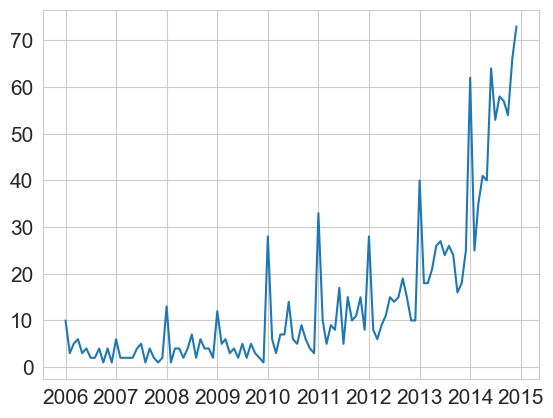

In [23]:
#visualização inicial
plt.plot(tsmonthly.index, tsmonthly.NUM_OCURR)

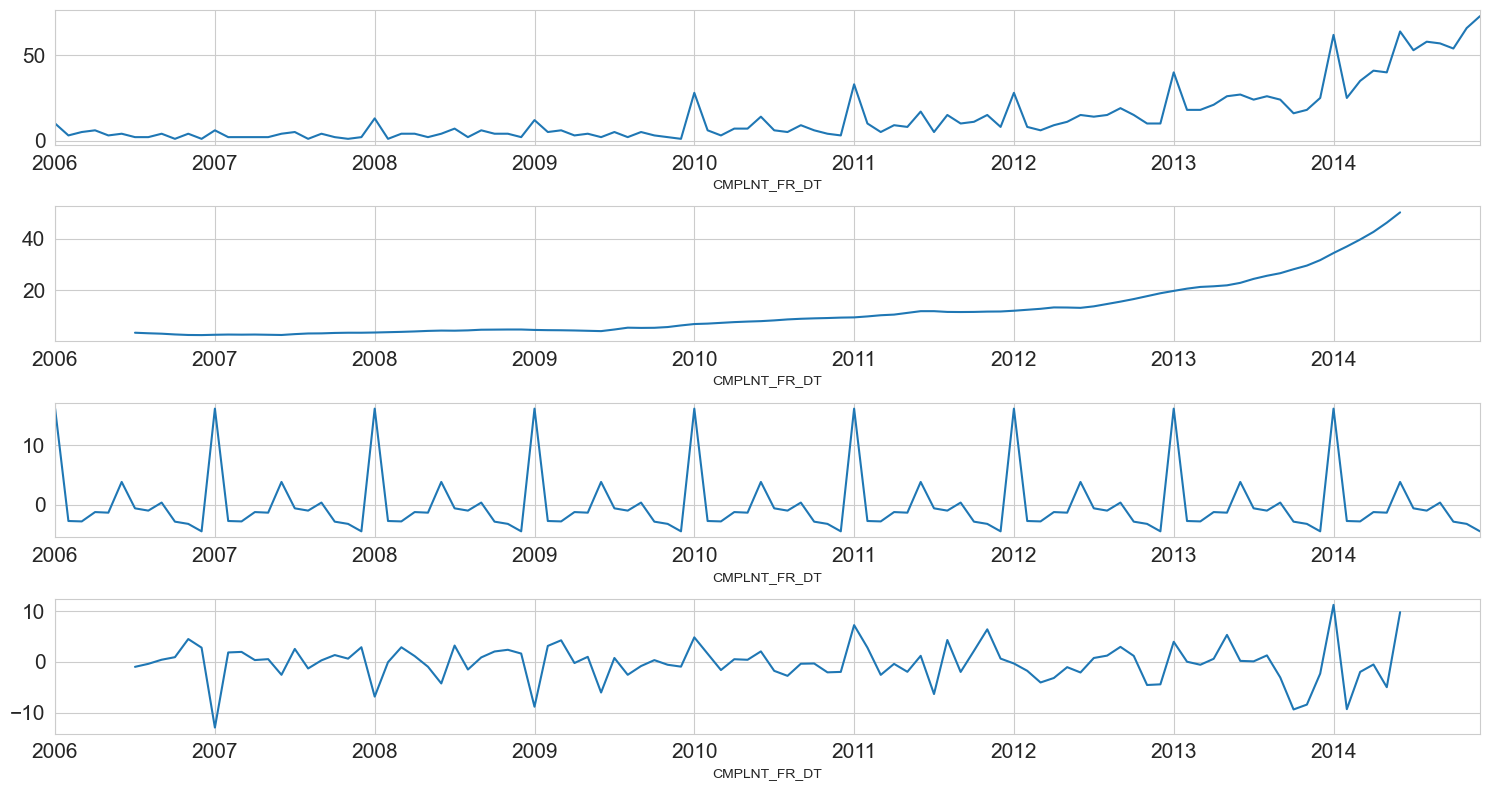

In [24]:
#DECOMPOSIÇÃO PARA O LAG MENSAL ENTRE 2011 E 2016

result_monthly = seasonal_decompose(tsmonthly)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
result_monthly.observed.plot(ax=ax1)
result_monthly.trend.plot(ax=ax2)
result_monthly.seasonal.plot(ax=ax3)
result_monthly.resid.plot(ax=ax4)
plt.tight_layout()

In [25]:
#organização da df para o seasonal plot
dfmonthly = dfmonthly[['CMPLNT_FR_DT', 'NUM_OCURR']]
dfmonthly['year'] = dfmonthly['CMPLNT_FR_DT'].dt.year
dfmonthly['month'] = dfmonthly['CMPLNT_FR_DT'].dt.month
dfmonthly = dfmonthly[['year', 'month', 'NUM_OCURR']]
dfmonthly

,year,month,NUM_OCURR
CMPLNT_FR_DT,,,
2006-01-01,2006,1,10
2006-02-01,2006,2,3
2006-03-01,2006,3,5
2006-04-01,2006,4,6
2006-05-01,2006,5,3
...,...,...,...
2014-08-01,2014,8,58
2014-09-01,2014,9,57
2014-10-01,2014,10,54


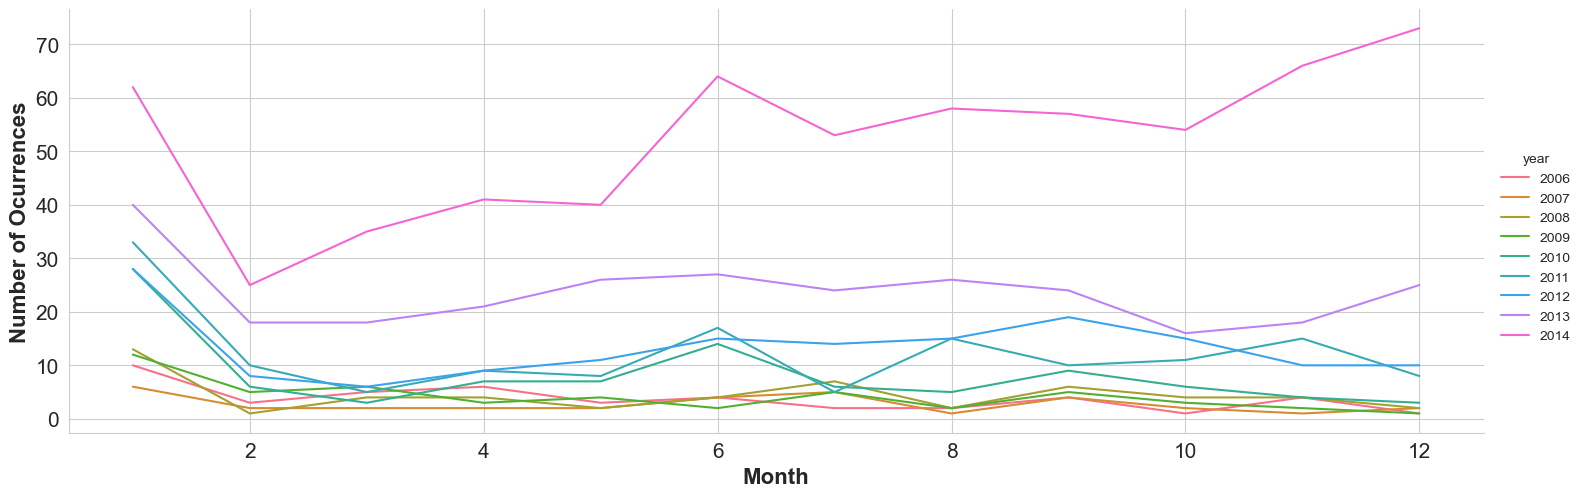

In [26]:
#seasonal plot
palette = sns.color_palette("husl", 9)

g = sns.relplot(x = 'month', y = 'NUM_OCURR', data= dfmonthly, kind ='line', hue='year', palette=palette, height=5, aspect=3)
g.set_axis_labels('Month', 'Number of Ocurrences', fontsize = 16, fontdict=dict(weight='bold'))

## Moving Average 

Calcule a média móvel da série temporal para suavizar a tendência e destacar a sazonalidade e os componentes de ciclo:

A média móvel simples (SMA) calcula a média dos valores em um intervalo fixo de pontos de dados ao longo do tempo. Por exemplo, uma SMA de ordem 5 calcula a média dos últimos 5 pontos de dados.

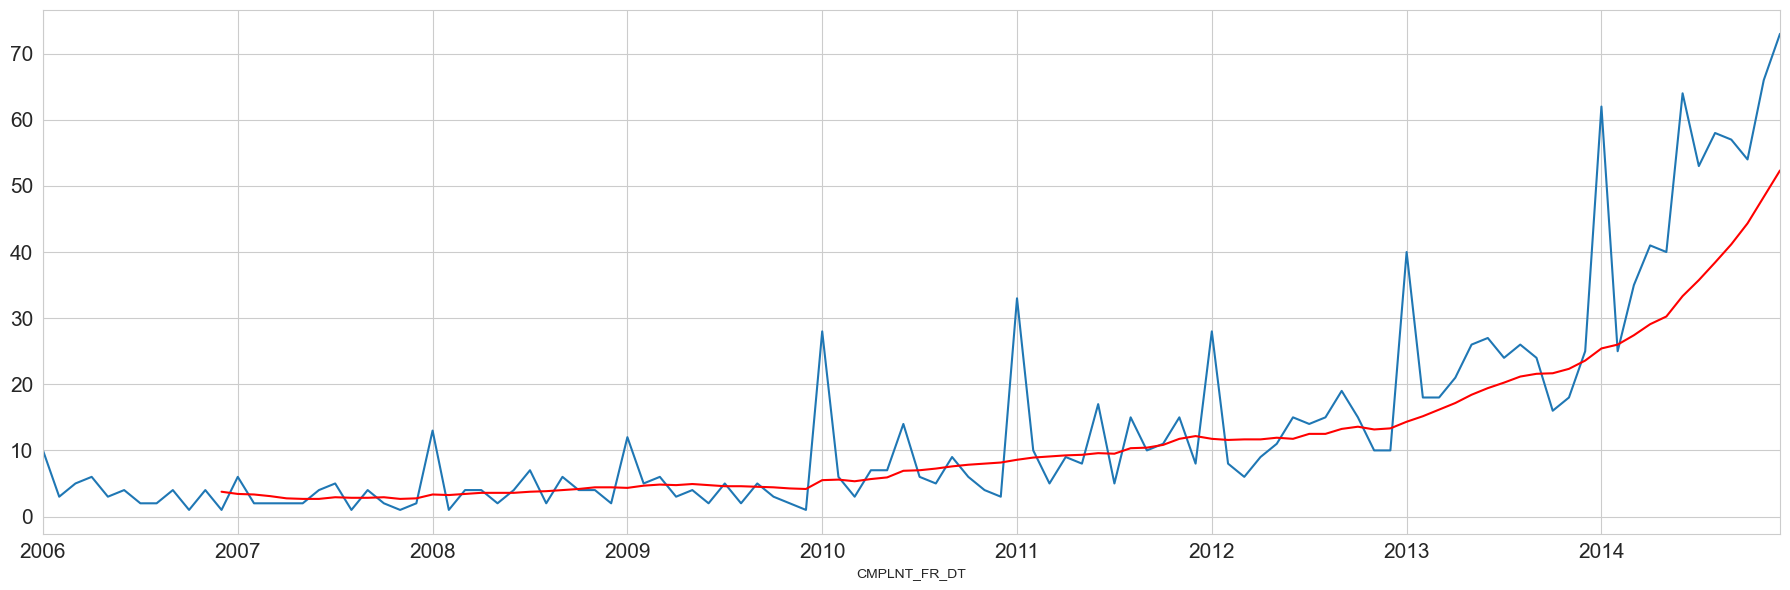

In [27]:
ma12 = tsmonthly.rolling(12).mean()

fig, ax = plt.subplots(figsize=(18, 6))
tsmonthly.plot(ax=ax, legend=False)
ma12.plot(ax=ax, legend=False, color='r')


plt.tight_layout()

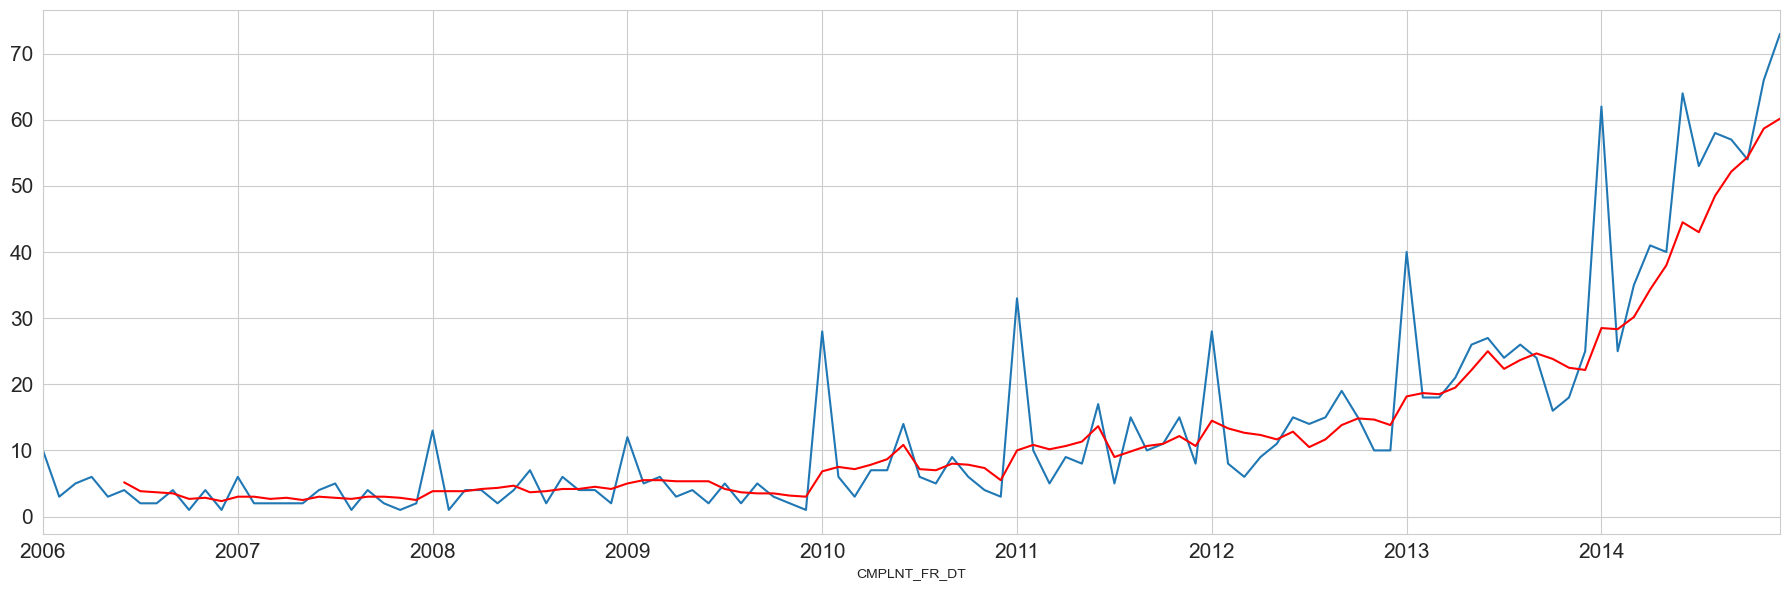

In [28]:
ma6 = tsmonthly.rolling(6).mean()

fig, ax = plt.subplots(figsize=(18, 6))
tsmonthly.plot(ax=ax, legend=False)
ma6.plot(ax=ax, legend=False, color='r')


plt.tight_layout()

A escolha da ordem deve ser feita com cuidado para obter resultados significativos e úteis, um valor menor para a ordem torna a suavização mais sensível às flutuações nos dados.

In [29]:
x = np.arange(0, len(tsmonthly.NUM_OCURR))

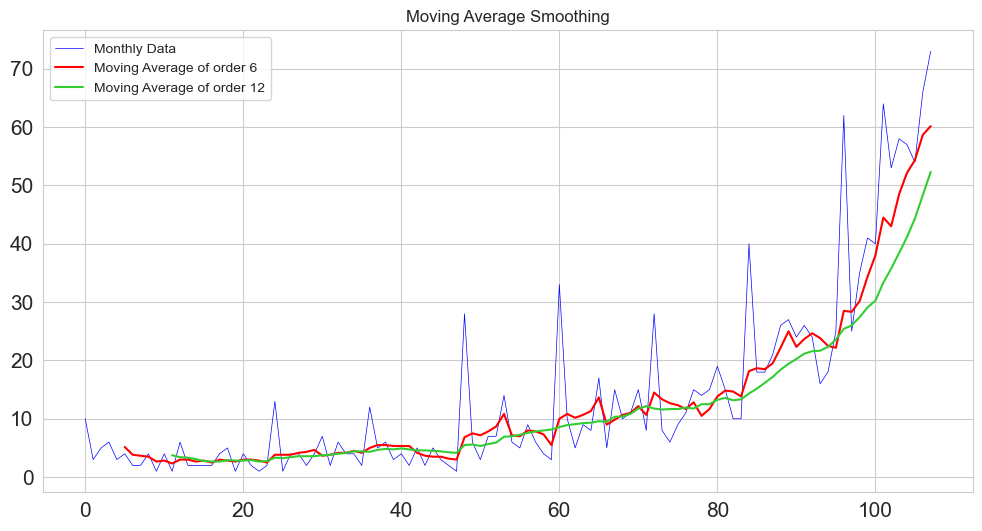

In [30]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=0.5,
    label="Monthly Data",
    color="blue",
)

ax.plot(
    x,
    tsmonthly.rolling(6).mean(),
    color="red",
    markersize=2,
    linestyle="-",
    label="Moving Average of order 6",
)

ax.plot(
    x,
    tsmonthly.rolling(12).mean(),
    color="limegreen",
    markersize=2.5,
    linestyle="-",
    label="Moving Average of order 12",
)

ax.set_title("Moving Average Smoothing")
ax.legend()

## Kernel Smoothing



In [31]:
#algoritimo de kernel para Largura de Banda = sigma

y = tsmonthly.NUM_OCURR.values
x = np.arange(0, len(tsmonthly.NUM_OCURR))

sigma = 6
smoothed_vals_6 = np.zeros(y.shape)
for x_position in x:
    kernel = np.exp(-((x - x_position) ** 2) / (2 * sigma**2))
    kernel = kernel / sum(kernel)
    smoothed_vals_6[x_position] = sum(y * kernel)

In [32]:
sigma = 12
smoothed_vals_12 = np.zeros(y.shape)
for x_position in x:
    kernel = np.exp(-((x - x_position) ** 2) / (2 * sigma**2))
    kernel = kernel / sum(kernel)
    smoothed_vals_12[x_position] = sum(y * kernel)

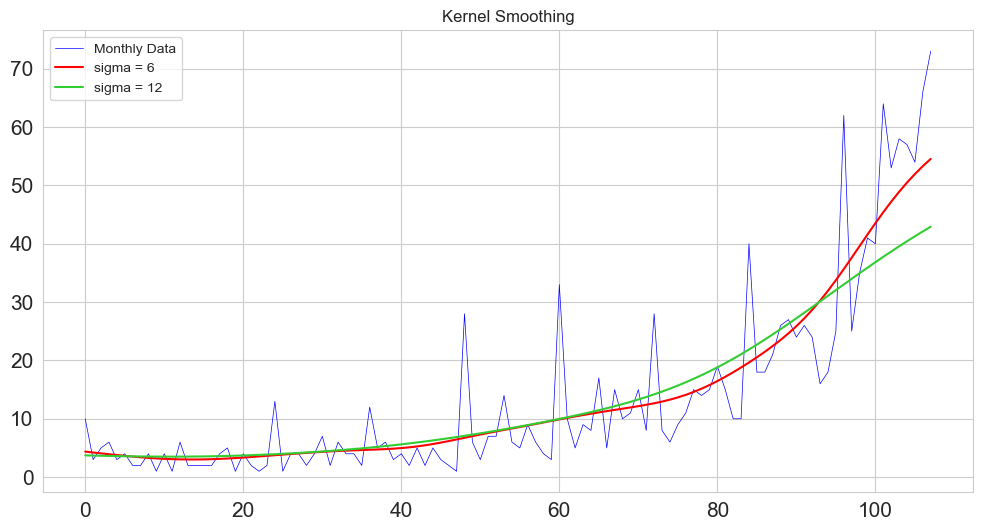

In [33]:
#gráficos das duas escolhas de largura de banda, 6 ou 12

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=0.5,
    label="Monthly Data",
    color="blue",
)

ax.plot(
    x,
    smoothed_vals_6,
    color="red",
    markersize=2,
    linestyle="-",
    label="sigma = 6",
)

ax.plot(
    x,
    smoothed_vals_12,
    color="limegreen",
    markersize=2.5,
    linestyle="-",
    label="sigma = 12",
)


ax.set_title("Kernel Smoothing")
ax.legend()

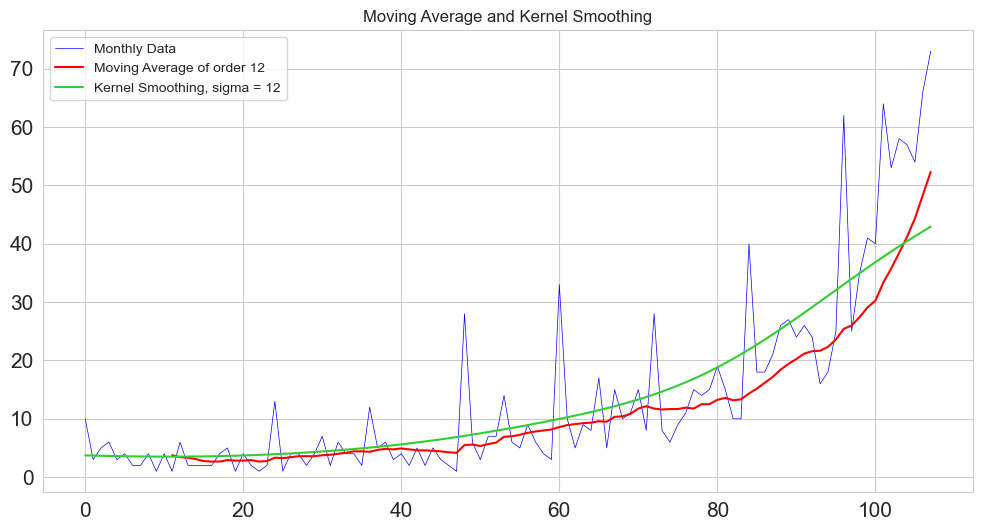

In [34]:
#comparação entre a estimativa da trend de kernel(12) e da média móvel(12) 

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=0.5,
    label="Monthly Data",
    color="blue",
)

ax.plot(
    x,
    tsmonthly.rolling(12).mean(),
    color="red",
    markersize=2,
    linestyle="-",
    label="Moving Average of order 12",
)

ax.plot(
    x,
    smoothed_vals_12,
    color="limegreen",
    markersize=2.5,
    linestyle="-",
    label="Kernel Smoothing, sigma = 12",
)

ax.set_title("Moving Average and Kernel Smoothing")
ax.legend()

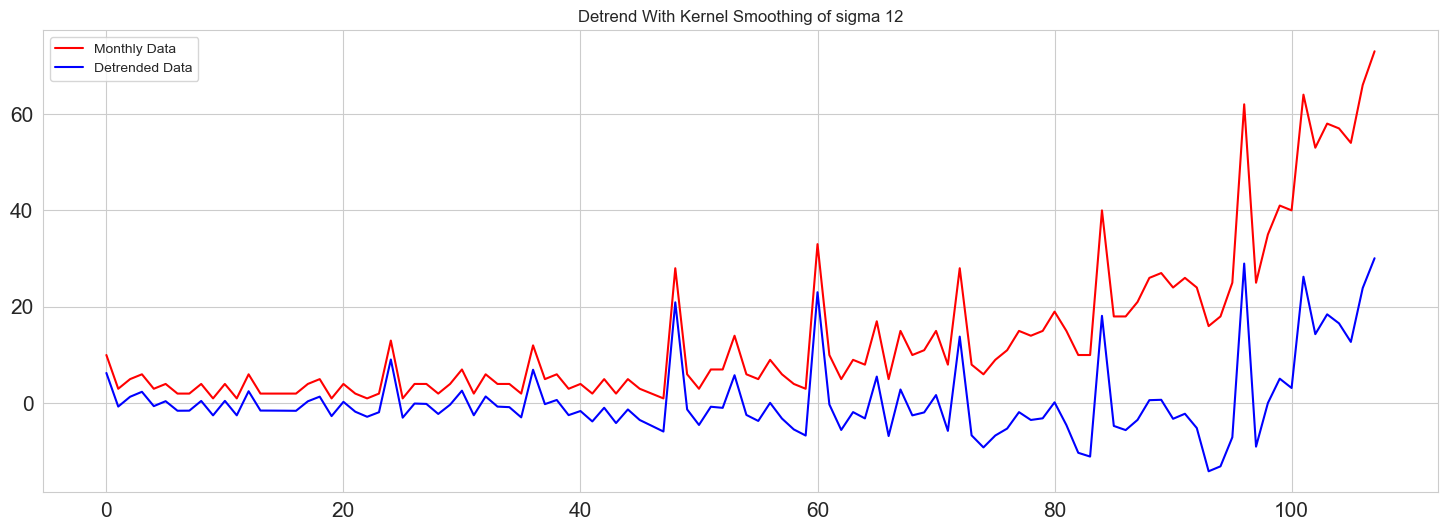

In [35]:
#remoção da trend com Kernel Smoothing of sigma 12
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=1.5,
    label="Monthly Data",
    color="red",
)

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values - smoothed_vals_12,
    linestyle="-",
    linewidth=1.5,
    label="Detrended Data",
    color="blue",
)

ax.set_title("Detrend With Kernel Smoothing of sigma 12")
ax.legend()

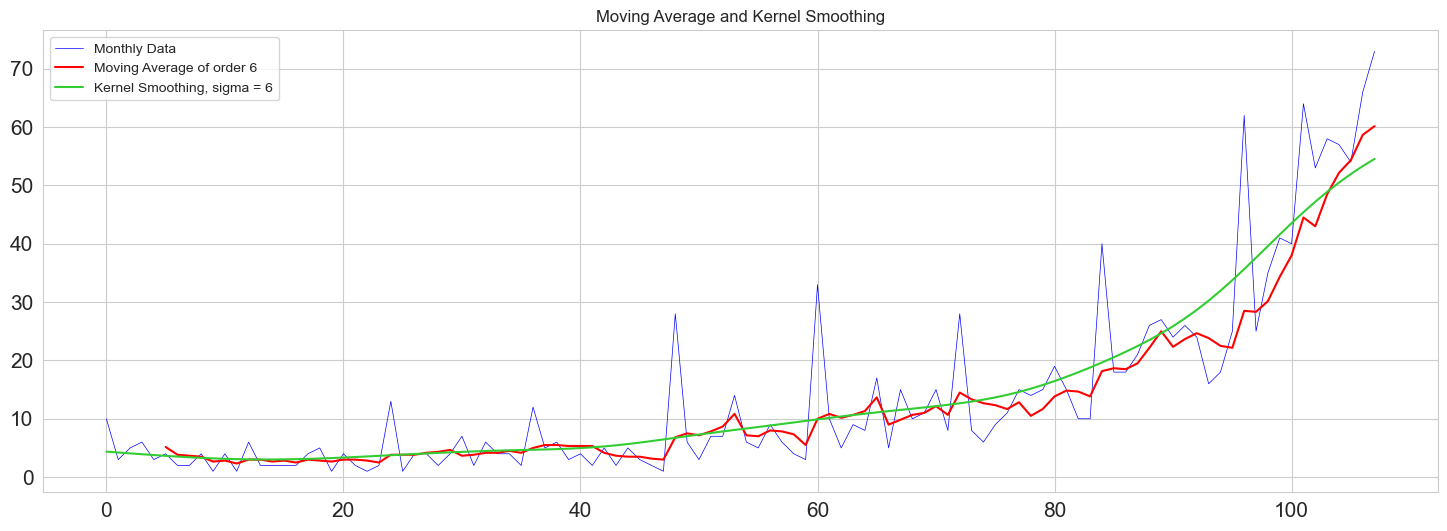

In [36]:
#comparação entre a estimativa da trend de kernel(6) e da média móvel(6) 

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=0.5,
    label="Monthly Data",
    color="blue",
)

ax.plot(
    x,
    tsmonthly.rolling(6).mean(),
    color="red",
    markersize=2,
    linestyle="-",
    label="Moving Average of order 6",
)

ax.plot(
    x,
    smoothed_vals_6,
    color="limegreen",
    markersize=2.5,
    linestyle="-",
    label="Kernel Smoothing, sigma = 6",
)

ax.set_title("Moving Average and Kernel Smoothing")
ax.legend()

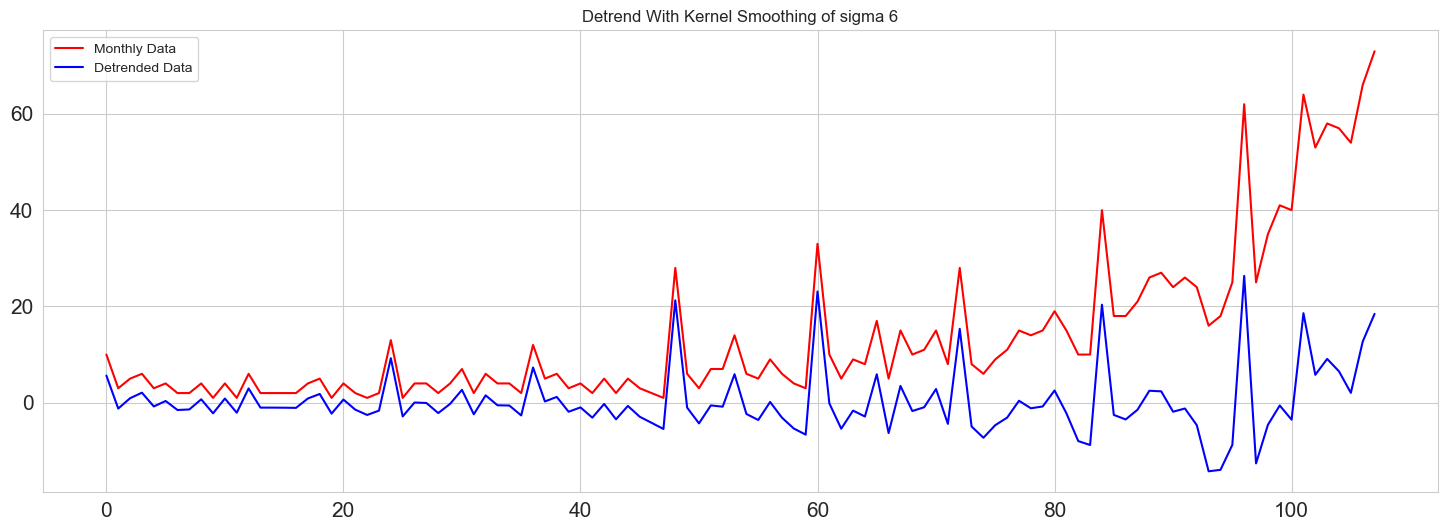

In [37]:
#remoção da trend com Kernel Smoothing of sigma 6
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values,
    linestyle="-",
    linewidth=1.5,
    label="Monthly Data",
    color="red",
)

ax.plot(
    x,
    tsmonthly.NUM_OCURR.values  - smoothed_vals_6,
    linestyle="-",
    linewidth=1.5,
    label="Detrended Data",
    color="blue",
)

ax.set_title("Detrend With Kernel Smoothing of sigma 6")
ax.legend()